In [42]:
# !pip install tensorflow-datasets
# !pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers


classess_name = {0: 'airplane',
 1:'automobile',
 2:'bird',
 3:'cat',
 4:'deer',
 5:'dog',
 6:'frog',
 7:'horse',
 8:'ship',
 9:'truck'}


print("classess_name: ", classess_name)

classess_name:  {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [43]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [44]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, Conv2D, MaxPool2D, Flatten, ZeroPadding2D
from keras.utils import np_utils
from pickle import dump, load
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

latent_dim = 2

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7 , 7 , 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="valid")(x)
x = layers.Conv2DTranspose(32, 1, activation="relu", strides=2, output_padding=(1))(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [45]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [46]:
from IPython.display import display
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import datasets
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.transform import resize

(x_train_o, y_train_o), (_, _) = datasets.cifar10.load_data()

def resize_img(x):    
    return resize(x, (128, 128))


print(x_train_o.shape)

x_train_by_lbl = {}
for i in range(0,10):
    x_train_by_lbl[i] = []

def get_sample_by_l():
    for i, x in enumerate(x_train_o):
        if y_train_o[i][0] == 1:
            x_train_by_lbl[y_train_o[i][0]].append(x.astype("float32") / 255)
        if i % 10000 == 1:
            print("Here, ", i)

get_sample_by_l()
print(len(x_train_by_lbl[1]))
print(len(x_train_by_lbl))

(50000, 32, 32, 3)
Here,  1
Here,  10001
Here,  20001
Here,  30001
Here,  40001
5000
10


In [42]:
import pickle
print(len(x_train_by_lbl[0]))
with open('up_scales_image_set_cifar10_class1.pickle', 'wb') as handle:
    pickle.dump(x_train_by_lbl[0], handle)

5000


Epoch 1/120
40/40 [==============================] - 3s 49ms/step - loss: 706.2690 - reconstruction_loss: 703.3829 - kl_loss: 0.0186
Epoch 2/120
40/40 [==============================] - 2s 49ms/step - loss: 698.0500 - reconstruction_loss: 695.8992 - kl_loss: 0.8356
Epoch 3/120
40/40 [==============================] - 2s 50ms/step - loss: 694.0719 - reconstruction_loss: 691.4451 - kl_loss: 1.6949
Epoch 4/120
40/40 [==============================] - 2s 50ms/step - loss: 690.1083 - reconstruction_loss: 688.2578 - kl_loss: 2.0846
Epoch 5/120
40/40 [==============================] - 2s 49ms/step - loss: 690.1711 - reconstruction_loss: 686.5167 - kl_loss: 2.4130
Epoch 6/120
40/40 [==============================] - 2s 49ms/step - loss: 684.6920 - reconstruction_loss: 680.3563 - kl_loss: 3.0434
Epoch 7/120
40/40 [==============================] - 2s 49ms/step - loss: 682.2503 - reconstruction_loss: 677.3307 - kl_loss: 3.7970
Epoch 8/120
40/40 [==============================] - 2s 50ms/step - l

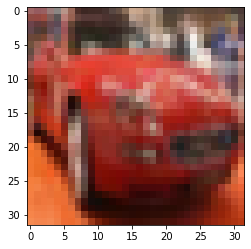

In [47]:
cifar_train = np.array(x_train_by_lbl[1]).reshape(len( x_train_by_lbl[1]), 32,32,3)
plt.imshow(cifar_train[1])

vae = VAE(encoder, decoder)
vae.compile(optimizer='Adam')
history = vae.fit(cifar_train ,epochs=120, batch_size=128)

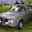

In [48]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

# vae.save(f'varietional_auto_encoder.h5')
vae.save_weights('varietional_auto_encoder_class1', overwrite=True, save_format=None, options=None)
display(array_to_img(cifar_train[3]))

In [49]:
vae.load_weights('varietional_auto_encoder_class1', by_name=False, skip_mismatch=False, options=None)

In [50]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    img_size = 32
    scale = 1.0
    figure = np.zeros((img_size * n, img_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


# plot_latent_space(vae)



def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)
    
    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]
    
    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2], 3)
    
    # Display some images
    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(20, 7))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()
    
    
    
# display_image_sequence(0,3,3,0,10)

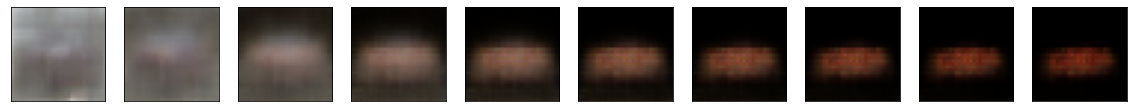

In [55]:
display_image_sequence(0,9, 9,0,10)